In [1]:
import os
import json
import torch
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import cProfile, pstats
from pandas.api.types import CategoricalDtype
from matplotlib import colormaps

from core.env.scene_manager import SceneManager, show_valid_score_map, draw_dependency_graph
from core.planners.planning_utils import env_cost, evaluate_alg

phi: 0.217 | uniform size: (19, 19)
Manipulator at [49, 49]


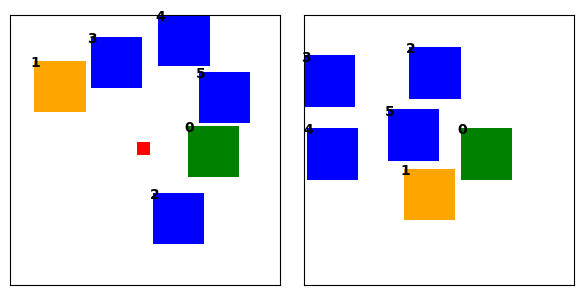

In [8]:
phi = 0.2
num_objects = 6
grid_size = (100, 100)

env = SceneManager(
	mode='stationary', num_objects=num_objects, 
	grid_size=grid_size, phi=phi, verbose=1
)
env.reset(use_stack=False, use_sides=False)
initial_scene, target_scene = env.initial_x.clone(), env.target_x.clone()
env.reset(initial_scene, target_scene)
env.render(show_manipulator=True, fig_size=3)
# show_valid_score_map(env, obj=0)
# draw_dependency_graph(env, fig_size=(2, 2))

In [9]:
from core.planners.Labbe import Labbe, Labbe_S
from core.planners.plan_optimizer import plan_refinement

plan = evaluate_alg(env, Labbe_S, initial_scene, target_scene, num_runs=1, c=0.1, time_limit=20)
print('-----')
plan_refinement(env, plan, initial_scene, target_scene, refine_mode="move", verbose=1);
print('-----')
plan_refinement(env, plan, initial_scene, target_scene, refine_mode="stack", verbose=1);

--------Labbe_S--------
plan: [5197, 45140, 54470, 28343, 16676, 32439, 22178]
elapsed_time: 0.102s
steps: 39
Moved 0 to: [51 67] | cost: 0.541 | done: False
Moved 4 to: [51 10] | cost: 1.305 | done: False
Moved 5 to: [44 40] | cost: 1.336 | done: False
Moved 2 to: [83 13] | cost: 1.077 | done: False
Moved 1 to: [66 46] | cost: 1.260 | done: False
Moved 3 to: [24  9] | cost: 1.003 | done: False
Moved 2 to: [21 48] | cost: 1.784 | done: True
episode cost: 8.305
-----
Buffer of obj 2 changed from pos [83, 13] to pos [25, 58]
cost got better from 8.305 to 7.433
-----
Buffer of obj 2 changed from pos [83, 13] to pos [25, 58]
cost got better from 8.305 to 7.433


In [10]:
from core.planners.Strap import Strap_S, StrapGA_S

# prof = cProfile.Profile()
# prof.enable()
plan = evaluate_alg(
	env, StrapGA_S, initial_scene, target_scene, 
	num_runs=1, score_sorting=False, static_stack=False,
	num_buffers=4, time_limit=2
);
# prof.disable()
# pstats.Stats(prof).sort_stats('tottime').print_stats(30);
print('-----')
plan_refinement(env, plan, initial_scene, target_scene, refine_mode="move", verbose=1)
print('-----')
plan_refinement(env, plan, initial_scene, target_scene, refine_mode="stack", verbose=1);

--------StrapGA_S--------
plan: [5197, 24067, 16676, 32439, 45140, 22178, 54470]
elapsed_time: 2.006s
steps: 852
Moved 0 to: [51 67] | cost: 0.541 | done: False
Moved 2 to: [40 37] | cost: 0.875 | done: False
Moved 1 to: [66 46] | cost: 0.924 | done: False
Moved 3 to: [24  9] | cost: 1.003 | done: False
Moved 4 to: [51 10] | cost: 1.454 | done: False
Moved 2 to: [21 48] | cost: 0.711 | done: False
Moved 5 to: [44 40] | cost: 1.040 | done: True
episode cost: 6.549
-----
Buffer of obj 2 changed from pos [40, 37] to pos [45, 29]
cost got better from 6.549 to 6.542
-----
Buffer of obj 2 changed from pos [40, 37] to pos [45, 29]
cost got better from 6.549 to 6.542


# Create

In [ ]:
from core.env.scene_utils import SceneCreator
config = {
    "num_cases": 5,
    "phi": 0.5,
    "grid_size": (100, 100),
    "n_values": [3, 4, 5, 6, 7, 8],
    "use_stack": False,
    "use_sides": False,
    "verbose": 1
}

creator = SceneCreator(config)
creator.create_scenes()

# Run

In [ ]:
from core.env.scene_utils import load_scene_metas, scene_meta_to_x

def save_runs(scene_metas, env, phi, alg, file_name, num_runs=1, **kwargs):
	dir_path = f'abstract_scenes/runs/phi_{phi}/{env.mode}/g{env.grid_size[0]}.{env.grid_size[1]}/n{env.N}'
	os.makedirs(dir_path, exist_ok=True)
	
	data_path = os.path.join(dir_path, f'{file_name}.csv')

	file_exists = os.path.exists(data_path)
	if file_exists:
		df = pd.read_csv(data_path, converters={
			'plans': eval, 'steps': eval,
			'elapsed_times': eval, 'costs': eval
		})
	else:
		df = pd.DataFrame()

	print(f'----{alg.__name__}:{file_name}----')
	total_runs = len(scene_metas) * num_runs
	pbar = tqdm(total=total_runs, unit='run')

	for scene_idx, scene_meta in enumerate(scene_metas):
		scene_id = scene_meta['scene_id']
		already_num_runs = 0
		remaining_num_runs = num_runs
		if file_exists and scene_id in df['scene_id'].values:
			idx = df.index[df['scene_id'] == scene_id][0]
			already_num_runs = len(df.at[idx, 'plans'])
			remaining_num_runs = num_runs - already_num_runs
			pbar.update(already_num_runs)
			if remaining_num_runs <= 0:
				pbar.set_description(f'Skipping scene {scene_id} - already solved {already_num_runs} times')
				continue

		for run_idx in range(1, remaining_num_runs + 1):
			pbar.set_description(f'Scene {scene_idx}/{len(scene_metas)} - Run {run_idx+already_num_runs}/{num_runs}')

			initial_x, target_x = scene_meta_to_x(scene_meta)
			initial_x, target_x = initial_x.to(torch.long), target_x.to(torch.long)
			env.reset(initial_x, target_x)
			plan, step, elapsed_time = alg(env).solve(**kwargs)
			cost = env_cost(env, plan, initial_x, target_x, log=False)

			if file_exists and scene_id in df['scene_id'].values:
				idx = df.index[df['scene_id'] == scene_id][0]
				df.at[idx, 'plans'] += [plan]
				df.at[idx, 'steps'] += [step]
				df.at[idx, 'elapsed_times'] += [elapsed_time]
				df.at[idx, 'costs'] += [cost]
			else:
				new_row = pd.DataFrame([{
					'scene_id': scene_id,
					'mode': env.mode,
					'n': scene_meta['num_objects'],
					'grid_size': scene_meta['grid_size'],
					'alg': file_name,
					'plans': [plan],
					'steps': [step],
					'elapsed_times': [elapsed_time],
					'costs': [cost],
				}])
				df = pd.concat([df, new_row], ignore_index=True)

			# Sort and save
			df = df.sort_values(by='scene_id').reset_index(drop=True)
			df.to_csv(data_path, index=False)
			file_exists = True

			pbar.update(1)
		pbar.set_description(f'Scene {scene_idx}/{len(scene_metas)} - Run {run_idx+already_num_runs}/{num_runs}')
		
	pbar.close()

def run_(num_runs, mode, num_objects, grid_size, phi, time_limit):
	num_buffers = 4
	env = SceneManager(
		mode=mode, num_objects=num_objects, 
		grid_size=grid_size, phi=phi, verbose=0
	)

	scene_metas = load_scene_metas(num_objects, grid_size, phi)

	save_runs(scene_metas, env, phi, Labbe, "Labbe", num_runs=num_runs, 
		c=0.1, time_limit=time_limit
	)
	save_runs(scene_metas, env, phi, Labbe_S, "Labbe+S", num_runs=num_runs, 
		c=0.1, time_limit=time_limit
	)
	save_runs(scene_metas, env, phi, StrapGA, f"StrapGA_{num_buffers}b", num_runs=num_runs, 
		num_buffers=num_buffers, time_limit=time_limit
	)
	save_runs(scene_metas, env, phi, StrapGA_S, f"StrapGA+S_{num_buffers}b", num_runs=num_runs, 
		num_buffers=num_buffers, time_limit=time_limit
	)

	save_runs(scene_metas, env, phi, Labbe_S, "Labbe+SS", num_runs=num_runs, 
		c=0.1, time_limit=time_limit, static_stack=True
	)
	save_runs(scene_metas, env, phi, StrapGA_S, f"StrapGA+SS_{num_buffers}b", num_runs=num_runs, 
		num_buffers=num_buffers, time_limit=time_limit, static_stack=True
	)

	# print('-- Score Sorting --')

	# save_runs(scene_metas, env, phi, StrapGA, f"StrapGA_sort_{num_buffers}b", num_runs=num_runs, 
	# 	num_buffers=num_buffers, time_limit=time_limit, score_sorting=True
	# )
	# save_runs(scene_metas, env, phi, StrapGA_S, f"StrapGA+S_sort_{num_buffers}b", num_runs=num_runs, 
	# 	num_buffers=num_buffers, time_limit=time_limit, score_sorting=True
	# )

	# save_runs(scene_metas, env, phi, StrapGA_S, f"StrapGA+SS_sort_{num_buffers}b", num_runs=num_runs, 
	# 	num_buffers=num_buffers, time_limit=time_limit, static_stack=True, score_sorting=True
	# )

phi = 0.2
num_runs = 1
time_limit = 360
grid_size = (100, 100)
mode = 'stationary'

run_(num_runs=num_runs, mode=mode, num_objects=3, grid_size=grid_size, phi=phi, time_limit=time_limit)

# Plots

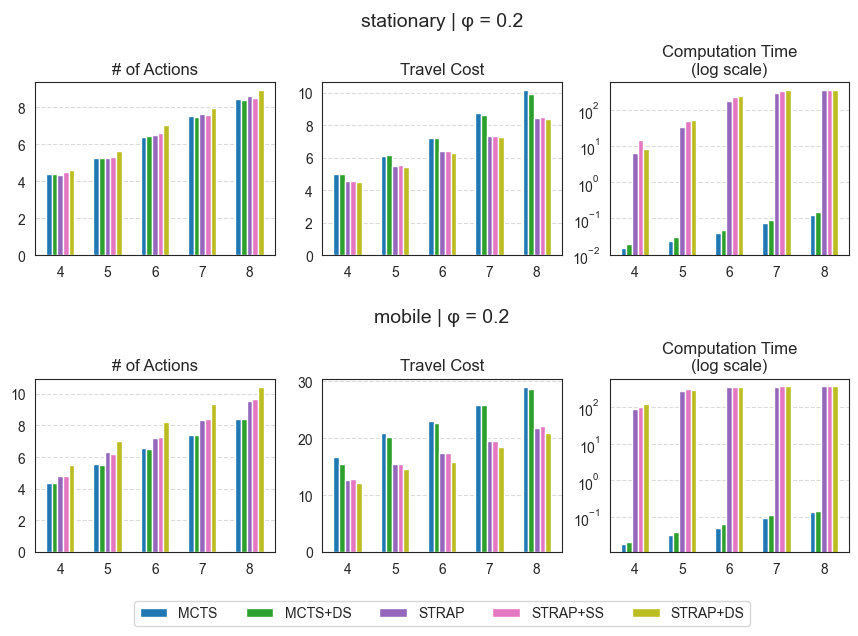

In [ ]:
from core.env.scene_utils import scene_meta_to_x

sns.set_style('white')

def load_runs(mode, grid_size, algs, n_values, phi, runs_dir='runs', refine_mode=None):
	all_dfs = []

	for num_objects in n_values:
		for alg_name in algs:
			filename = f'{runs_dir}/phi_{phi}/{mode}/g{grid_size[0]}.{grid_size[1]}/n{num_objects}/{alg_name}.csv'
			if not os.path.isfile(filename):
				continue

			# Read CSV
			df = pd.read_csv(filename)

			if refine_mode is not None:
				# Determine refinement algorithm based on alg_name
				if 'Labbe+SS' in alg_name or 'StrapGA+SS' in alg_name:
					static_stack = True
				elif 'Labbe+S' in alg_name or 'StrapGA+S' in alg_name:
					static_stack = False
				else:
					static_stack = False

				# Create temporary environment for refinement
				temp_env = SceneManager(
					mode=mode, num_objects=num_objects, grid_size=grid_size, 
					static_stack=static_stack, phi=phi, verbose=0
				)
				
				# Process each row for refinement
				for idx, row in df.iterrows():
					scene_id = row['scene_id']
					plans = eval(row['plans'])
					steps = eval(row['steps'])
					elapsed_times = eval(row['elapsed_times'])
					costs = eval(row['costs'])
					
					refined_plans = []
					refined_costs = []
					refined_elapsed_times = []
					
					# Load the corresponding scene
					scene_filename = f'abstract_scenes/scenes/phi_{phi}/g{grid_size[0]}.{grid_size[1]}/n{num_objects}/scene_{scene_id:04d}.json'
					if os.path.exists(scene_filename):
						with open(scene_filename, 'r') as f:
							json_scene = json.load(f)
						initial_x, target_x = scene_meta_to_x(json_scene)
						
						# Refine each run
						for i, (plan, elapsed_time, cost) in enumerate(zip(plans, elapsed_times, costs)):
							if plan is not None and cost is not None:
								temp_env.reset(initial_x, target_x)
								
								refined_plan, refined_cost, refinement_time = plan_refinement(
									temp_env, plan, initial_x, target_x, refine_mode, verbose=0
								)
								
								refined_plans.append(refined_plan)
								refined_costs.append(refined_cost)
								refined_elapsed_times.append(elapsed_time + refinement_time)
							else:
								# Keep failed runs as they are
								refined_plans.append(plan)
								refined_costs.append(cost)
								refined_elapsed_times.append(elapsed_time)
					else:
						print(f"Warning: Scene file {scene_filename} not found. Skipping refinement for scene {scene_id}")
						refined_plans = plans
						refined_costs = costs
						refined_elapsed_times = elapsed_times
					
					# Update the dataframe row
					df.at[idx, 'plans'] = str(refined_plans)
					df.at[idx, 'costs'] = str(refined_costs)
					df.at[idx, 'elapsed_times'] = str(refined_elapsed_times)

			# calculate the mean not-None costs
			df['cost'] = df['costs'].apply(lambda x: 
				np.mean([cost for cost in eval(x) if cost is not None]) 
				if isinstance(eval(x), list) and any(cost is not None for cost in eval(x)) 
				else np.nan
			)
			df['step'] = df['steps'].apply(lambda x: np.mean([step for step in eval(x)]))
			df['elapsed_time'] = df['elapsed_times'].apply(lambda x: np.mean([time for time in eval(x)]))
			# Add plan length calculation
			df['plan_length'] = df['plans'].apply(lambda x: 
				np.mean([len(plan) for plan in eval(x) if plan is not None]) 
				if isinstance(eval(x), list) and any(plan is not None for plan in eval(x)) 
				else np.nan
			)

			all_dfs.append(df)

	# Merge all into one big DataFrame
	if all_dfs:
		merged_df = pd.concat(all_dfs, ignore_index=True)
		return merged_df
	else:
		print("No valid run files found.")
		return pd.DataFrame()  # Return empty DF if nothing was loaded

def process_algorithm_data(df, include_std=False):
	"""
	Process algorithm comparison data and create pivot tables for plotting.
	
	Parameters:
	df: Input dataframe with algorithm results
	include_std: Whether to include standard deviation data
	
	Returns:
	dict: Contains all processed data organized by metric type
	"""
	# Filter successful runs (cost not null = successful run)
	df['success'] = df['cost'].notna()
	df_successful = df[df['success']].copy()
	
	# Preserve algorithm order as they appear in the dataframe
	alg_order = df['alg'].drop_duplicates().tolist()
	alg_dtype = CategoricalDtype(categories=alg_order, ordered=True)
	df['alg'] = df['alg'].astype(alg_dtype)
	df_successful['alg'] = df_successful['alg'].astype(alg_dtype)
	
	# Group data for aggregation
	grouped_successful = df_successful.groupby(['n', 'alg'])
	grouped_all = df.groupby(['n', 'alg'])
	
	# Calculate aggregated metrics for successful runs
	agg_successful = grouped_successful.agg(
		cost_mean=('cost', 'mean'),
		cost_std=('cost', 'std'),
		step_mean=('step', 'mean'),
		step_std=('step', 'std'),
		time_mean=('elapsed_time', 'mean'),
		time_std=('elapsed_time', 'std'),
		plan_length_mean=('plan_length', 'mean'),
		plan_length_std=('plan_length', 'std')
	).reset_index()
	
	# Calculate success rate using all runs
	agg_all = grouped_all.agg(
		success_rate=('success', lambda x: 100 * x.sum() / len(x))
	).reset_index()
	
	# Ensure algorithm column ordering is preserved
	agg_successful['alg'] = agg_successful['alg'].astype(alg_dtype)
	agg_all['alg'] = agg_all['alg'].astype(alg_dtype)
	
	# Create pivot tables for plotting
	mean_data = {
		'cost': agg_successful.pivot(index='n', columns='alg', values='cost_mean')[alg_order],
		'step': agg_successful.pivot(index='n', columns='alg', values='step_mean')[alg_order],
		'time': agg_successful.pivot(index='n', columns='alg', values='time_mean')[alg_order],
		'plan_length': agg_successful.pivot(index='n', columns='alg', values='plan_length_mean')[alg_order],
		'success_rate': agg_all.pivot(index='n', columns='alg', values='success_rate')[alg_order]
	}
	
	std_data = {}
	if include_std:
		std_data = {
			'cost': agg_successful.pivot(index='n', columns='alg', values='cost_std')[alg_order],
			'step': agg_successful.pivot(index='n', columns='alg', values='step_std')[alg_order],
			'time': agg_successful.pivot(index='n', columns='alg', values='time_std')[alg_order],
			'plan_length': agg_successful.pivot(index='n', columns='alg', values='plan_length_std')[alg_order]
		}
	
	return {
		'mean': mean_data,
		'std': std_data,
		'algorithm_order': alg_order
	}

def draw_row(axs, data, std, sr, steps, plan_len, cmap):
    """Shared function to draw algorithm comparison plots in a row."""
    idx = 0
    if plan_len:
        plot_algorithm_bars(data['mean']['plan_length'], '# of Actions', '',
                            data['std'].get('plan_length'), ax=axs[idx], cmap=cmap, show_legend=False)
        idx += 1
    plot_algorithm_bars(data['mean']['cost'], 'Travel Cost', '',
                        data['std'].get('cost'), ax=axs[idx], cmap=cmap, show_legend=False)
    idx += 1
    plot_algorithm_bars(data['mean']['time'], 'Computation Time\n(log scale)', '',
                        data['std'].get('time'), log_scale=True, ax=axs[idx], cmap=cmap, show_legend=False)
    idx += 1
    if steps:
        st = data['mean']['step'] / 1000
        ss = data['std'].get('step') / 1000 if std and 'step' in data['std'] else None
        plot_algorithm_bars(st, 'Step Comparison\n(in thousands)', '', ss, ax=axs[idx], cmap=cmap, show_legend=False)
        idx += 1
    if sr:
        plot_algorithm_bars(data['mean']['success_rate'], 'Success Rate (%)', '', ax=axs[idx], cmap=cmap, show_legend=False)

def compare_algorithms_single_row(df, std=False, sr=False, steps=False, plan_len=False, title=''):
    """
    Create a single row of comparison plots for algorithms.
    """
    if df.empty:
        print("No data to compare.")
        return {}

    processed_data = process_algorithm_data(df, include_std=std)
    mean_data, std_data = processed_data['mean'], processed_data['std']

    # return {'cost': mean_data['cost'], 'plan_length': mean_data['plan_length'], 'success_rate': mean_data['success_rate']}

    num_plots = 2 + sum([sr, steps, plan_len])
    plot_w, plot_h = 3.5, 3
    fig_h = plot_h + 1.5  # increased for more spacing
    fig = plt.figure(figsize=(num_plots * plot_w, fig_h))
    gs = fig.add_gridspec(3, num_plots, height_ratios=[0.6, plot_h, 0.6], hspace=0.6)  # increased spacing

    # Title row
    ax_title = fig.add_subplot(gs[0, :])
    ax_title.axis('off')
    ax_title.text(0.5, 0.5, title, ha='center', va='center', fontsize=14)

    # Plot row
    axs = [fig.add_subplot(gs[1, i]) for i in range(num_plots)]
    cmap = colormaps['tab10']
    
    # Use shared draw_row function
    draw_row(axs, processed_data, std, sr, steps, plan_len, cmap)

    # Legend row
    ax_legend = fig.add_subplot(gs[2, :])
    ax_legend.axis('off')
    handles, labels = axs[0].get_legend_handles_labels()
    ax_legend.legend(handles, labels, ncol=len(labels), loc='center')

    plt.show()
    return {'cost': mean_data['cost'], 'plan_length': mean_data['plan_length'], 'success_rate': mean_data['success_rate']}

def compare_algorithms_double_row(df1, df2, std=False, sr=False, steps=False, plan_len=False,
                                title1='', title2=''):
    """
    Create two rows of comparison plots with identical plot-area sizes and consistent spacing.
    """
    if df1.empty or df2.empty:
        print("No data to compare.")
        return {}

    d1 = process_algorithm_data(df1, include_std=std)
    d2 = process_algorithm_data(df2, include_std=std)

    num_plots = 2 + sum([sr, steps, plan_len])
    plot_w, plot_h = 3.5, 3
    fig_h = 2 * plot_h + 2.0  # increased for more spacing
    fig = plt.figure(figsize=(num_plots * plot_w, fig_h))
    gs = fig.add_gridspec(5, num_plots,
                        height_ratios=[0.4, plot_h, 0.4, plot_h, 0.4],
                        hspace=0.6)  # increased spacing

    # Title1
    ax_t1 = fig.add_subplot(gs[0, :]); ax_t1.axis('off')
    ax_t1.text(0.5, 0.5, title1, ha='center', va='center', fontsize=14)
    # Plots1
    axs1 = [fig.add_subplot(gs[1, i]) for i in range(num_plots)]
    # Title2
    ax_t2 = fig.add_subplot(gs[2, :]); ax_t2.axis('off')
    ax_t2.text(0.5, 0.5, title2, ha='center', va='center', fontsize=14)
    # Plots2
    axs2 = [fig.add_subplot(gs[3, i]) for i in range(num_plots)]
    cmap = colormaps['tab10']
    
    # Use shared draw_row function for both rows
    draw_row(axs1, d1, std, sr, steps, plan_len, cmap)
    draw_row(axs2, d2, std, sr, steps, plan_len, cmap)

    # Legend
    ax_leg = fig.add_subplot(gs[4, :]); ax_leg.axis('off')
    handles, labels = axs1[0].get_legend_handles_labels()
    ax_leg.legend(handles, labels, ncol=len(labels), loc='center')

    plt.show()

def plot_algorithm_bars(df, title, ylabel, std_data=None, log_scale=False, ax=None, cmap=None, show_legend=True):
	"""
	Create bar plots for algorithm comparison with proper labeling.
	
	Parameters:
	df: Pivot table with algorithm data
	title: Plot title
	ylabel: Y-axis label
	std_data: Standard deviation data for error bars
	log_scale: Whether to use log scale for y-axis
	ax: Matplotlib axes object
	cmap: Color map for bars
	show_legend: Whether to show legend
	"""
	if ax is None:
		fig, ax = plt.subplots(figsize=(6, 4))

	n_values = df.index.tolist()
	algorithms = df.columns.tolist()
	x = np.arange(len(n_values))
	bar_width = 0.12

	colors = [cmap(i / len(algorithms)) for i in range(len(algorithms))]

	# Algorithm name mapping for cleaner labels
	label_mapping = {
		'StrapGA+S_4b': 'STRAP+DS',
		'StrapGA+SS_4b': 'STRAP+SS',
		'StrapGA_4b': 'STRAP',
		'Labbe': 'MCTS',
		'Labbe+S': 'MCTS+DS',
		'Labbe+SS': 'MCTS+SS'
	}

	for i, alg in enumerate(algorithms):
		values = df[alg].values
		errors = std_data[alg].values if std_data is not None and alg in std_data.columns else None
		label = label_mapping.get(alg, alg)

		ax.bar(x + i * bar_width, values, width=bar_width, color=colors[i], 
			label=label, yerr=errors, capsize=5 if errors is not None else 0)

	ax.set_xlabel('')
	ax.set_ylabel(ylabel)
	ax.set_title(title)
	ax.set_xticks(x + bar_width * (len(algorithms) - 1) / 2)
	ax.set_xticklabels(n_values)
	
	if show_legend:
		ax.legend(title='Algorithm')

	if log_scale:
		ax.set_yscale('log')

	ax.grid(axis='y', linestyle='--', alpha=0.7)

def performance_improvement_rate(df1, df2, alg1, alg2):
	ESC1 = df1['cost'][alg1] / df1['success_rate'][alg1] * 100
	ESC2 = df2['cost'][alg2] / df2['success_rate'][alg2] * 100

	OPS1 = ESC1.mean()
	OPS2 = ESC2.mean()

	PIR = (OPS1 - OPS2) / OPS1 * 100
	return OPS1, OPS2, PIR

phi = 0.2
n_values = [4,5,6,7,8]
algs = ["Labbe", "Labbe+S", "StrapGA_4b", "StrapGA+SS_4b", "StrapGA+S_4b"]

mode = 'stationary'
grid_size = (100, 100)
df1 = load_runs(mode, grid_size, algs, n_values, phi, runs_dir='abstract_scenes/runs')
title1 = f'{mode} | φ = {phi}'

mode = 'mobile'
grid_size = (101, 201)
df2 = load_runs(mode, grid_size, algs, n_values, phi, runs_dir='abstract_scenes/runs')
title2 = f'{mode} | φ = {phi}'
compare_algorithms_double_row(df1, df2, plan_len=True, title1=title1, title2=title2);

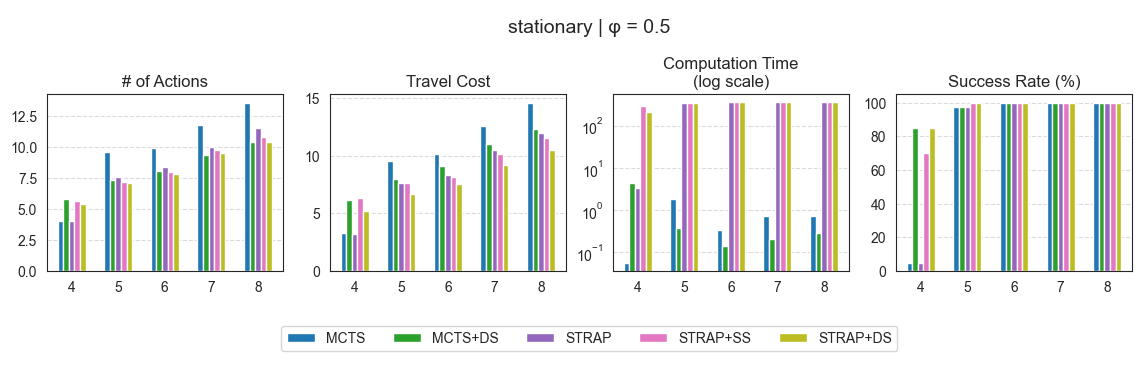

In [12]:
phi = 0.5
mode = 'stationary'
grid_size = (100, 100)
df3 = load_runs(mode, grid_size, algs, n_values, phi, runs_dir='abstract_scenes/runs')
title3 = f'{mode} | φ = {phi}'
compare_algorithms_single_row(df3, sr=True, plan_len=True, title=title3);

### PIR Results

In [ ]:
dict_p = {
	'phis': [0.2, 0.2, 0.5],
	'modes': ['stationary', 'mobile', 'stationary'],
	'grid_sizes': [(100, 100), (101, 201), (100, 100)],
}

for phi, mode, grid_size in zip(dict_p['phis'], dict_p['modes'], dict_p['grid_sizes']):

	n_values = [4,5,6,7,8]
	algs = ["Labbe", "Labbe+S", "StrapGA_4b", "StrapGA+SS_4b", "StrapGA+S_4b"]
	df = load_runs(mode, grid_size, algs, n_values, phi, runs_dir='abstract_scenes/runs')
	data = {k: v for k, v in process_algorithm_data(df)['mean'].items() if k in ['cost', 'plan_length', 'success_rate']}
	for key in data.keys():
		data[key].columns = ['MCTS', 'MCTS+DS', 'STRAP', 'STRAP+SS', 'STRAP+DS']
		if phi == 0.5 and mode == 'stationary':
			data[key] = data[key].drop(4)

	print(f'--φ:{phi}, mode:{mode}--')
	OPS1, OPS2, PIR = performance_improvement_rate(data, data, 'STRAP', 'STRAP+SS')
	print(f'STRAP+SS ({OPS2:.2f}) over STRAP({OPS1:.2f}): {PIR:.2f}%')
	OPS1, OPS2, PIR = performance_improvement_rate(data, data, 'STRAP', 'STRAP+DS')
	print(f'STRAP+DS ({OPS2:.2f}) over STRAP({OPS1:.2f}): {PIR:.2f}%')
	OPS1, OPS2, PIR = performance_improvement_rate(data, data, 'MCTS', 'MCTS+DS')
	print(f'MCTS+DS  ({OPS2:.2f}) over MCTS ({OPS1:.2f}): {PIR:.2f}%')


--φ:0.2, mode:stationary--
STRAP+SS (6.49) over STRAP(6.46): -0.46%
STRAP+DS (6.37) over STRAP(6.46): 1.31%
MCTS+DS  (7.38) over MCTS (7.45): 0.92%
--φ:0.2, mode:mobile--
STRAP+SS (17.50) over STRAP(17.40): -0.61%
STRAP+DS (16.41) over STRAP(17.40): 5.69%
MCTS+DS  (22.55) over MCTS (23.08): 2.30%
--φ:0.5, mode:stationary--
STRAP+SS (9.35) over STRAP(9.64): 2.96%
STRAP+DS (8.49) over STRAP(9.64): 11.89%
MCTS+DS  (10.14) over MCTS (11.75): 13.72%


### Num_buffer Parameter Study

In [14]:
phi = 0.2
mode = 'mobile'
n_values = [4,5,6,7,8]
grid_size = (101, 201)
algs = ["StrapGA_3b", "StrapGA_4b", "StrapGA_6b", "StrapGA_8b", "StrapGA_10b", "StrapGA+S_3b", "StrapGA+S_4b", "StrapGA+S_6b", "StrapGA+S_8b", "StrapGA+S_10b"]
df = load_runs(mode, grid_size, algs, n_values, phi, runs_dir='abstract_scenes/runs')
data = {k: v for k, v in process_algorithm_data(df)['mean'].items() if k in ['cost', 'plan_length', 'success_rate']}
PIR = performance_improvement_rate(data, data, 'StrapGA_3b', 'StrapGA+S_3b')
print(f'StrapGA+S_3b ({PIR[1]:.2f}) over StrapGA_3b({PIR[0]:.2f}): {PIR[2]:.2f}%')
PIR = performance_improvement_rate(data, data, 'StrapGA_4b', 'StrapGA+S_4b')
print(f'StrapGA+S_4b ({PIR[1]:.2f}) over StrapGA_4b({PIR[0]:.2f}): {PIR[2]:.2f}%')
PIR = performance_improvement_rate(data, data, 'StrapGA_6b', 'StrapGA+S_6b')
print(f'StrapGA+S_5b ({PIR[1]:.2f}) over StrapGA_6b({PIR[0]:.2f}): {PIR[2]:.2f}%')
PIR = performance_improvement_rate(data, data, 'StrapGA_8b', 'StrapGA+S_8b')
print(f'StrapGA+S_8b ({PIR[1]:.2f}) over StrapGA_8b({PIR[0]:.2f}): {PIR[2]:.2f}%')
PIR = performance_improvement_rate(data, data, 'StrapGA_10b', 'StrapGA+S_10b')
print(f'StrapGA+S_10b ({PIR[1]:.2f}) over StrapGA_10b({PIR[0]:.2f}): {PIR[2]:.2f}%')

StrapGA+S_3b (16.57) over StrapGA_3b(17.45): 5.02%
StrapGA+S_4b (16.41) over StrapGA_4b(17.40): 5.69%
StrapGA+S_5b (16.44) over StrapGA_6b(17.34): 5.14%
StrapGA+S_8b (16.48) over StrapGA_8b(17.42): 5.42%
StrapGA+S_10b (16.62) over StrapGA_10b(17.41): 4.54%


### Refinement Study

#### phi=0.2, stationary

In [17]:
phi = 0.2
mode = 'stationary'
grid_size = (100, 100)

n_values = [4,5,6,7,8]
algs = ["Labbe", "Labbe+S", "StrapGA_4b", "StrapGA+SS_4b", "StrapGA+S_4b"]
df = load_runs(mode, grid_size, algs, n_values, phi, runs_dir='abstract_scenes/runs')
data = {k: v for k, v in process_algorithm_data(df)['mean'].items() if k in ['cost', 'plan_length', 'success_rate']}
df_move = load_runs(mode, grid_size, algs, n_values, phi, runs_dir='abstract_scenes/runs', refine_mode="move")
data_move = {k: v for k, v in process_algorithm_data(df_move)['mean'].items() if k in ['cost', 'plan_length', 'success_rate']}
df_stack = load_runs(mode, grid_size, algs, n_values, phi, runs_dir='abstract_scenes/runs', refine_mode="stack")
data_stack = {k: v for k, v in process_algorithm_data(df_stack)['mean'].items() if k in ['cost', 'plan_length', 'success_rate']}

In [19]:
algs = ['MCTS', 'MCTS+DS', 'STRAP', 'STRAP+SS', 'STRAP+DS']

for key in data.keys():
	data[key].columns = algs
	data_move[key].columns = algs
	data_stack[key].columns = algs
	if phi == 0.5 and mode == 'stationary':
		data[key] = data[key].drop(4)
		data_move[key] = data_move[key].drop(4)
		data_stack[key] = data_stack[key].drop(4)

print(f'--φ:{phi}, mode:{mode}--')
print(f"---------Refinement: Move---------")
for alg in algs:
	OPS1, OPS2, PIR = performance_improvement_rate(data, data_move, alg, alg)
	print(f'{alg}:  ({OPS1:.2f})->({OPS2:.2f}) {PIR:.2f}%')
print(f"---------Refinement: Stack---------")
for alg in algs:
	OPS1, OPS2, PIR = performance_improvement_rate(data, data_stack, alg, alg)
	print(f'{alg}:  ({OPS1:.2f})->({OPS2:.2f}) {PIR:.2f}%')

--φ:0.2, mode:stationary--
---------Refinement: Move---------
MCTS:  (7.45)->(7.11) 4.52%
MCTS+DS:  (7.38)->(7.10) 3.84%
STRAP:  (6.46)->(6.41) 0.74%
STRAP+SS:  (6.49)->(6.43) 0.84%
STRAP+DS:  (6.37)->(6.35) 0.43%
---------Refinement: Stack---------
MCTS:  (7.45)->(7.10) 4.64%
MCTS+DS:  (7.38)->(7.09) 3.93%
STRAP:  (6.46)->(6.41) 0.80%
STRAP+SS:  (6.49)->(6.43) 0.94%
STRAP+DS:  (6.37)->(6.35) 0.43%


### phi=0.2, mobile

In [15]:
phi = 0.2
mode = 'mobile'
grid_size = (101, 201)

n_values = [4,5,6,7,8]
algs = ["Labbe", "Labbe+S", "StrapGA_4b", "StrapGA+SS_4b", "StrapGA+S_4b"]
df = load_runs(mode, grid_size, algs, n_values, phi, runs_dir='abstract_scenes/runs')
data = {k: v for k, v in process_algorithm_data(df)['mean'].items() if k in ['cost', 'plan_length', 'success_rate']}
df_move = load_runs(mode, grid_size, algs, n_values, phi, runs_dir='abstract_scenes/runs', refine_mode="move")
data_move = {k: v for k, v in process_algorithm_data(df_move)['mean'].items() if k in ['cost', 'plan_length', 'success_rate']}
df_stack = load_runs(mode, grid_size, algs, n_values, phi, runs_dir='abstract_scenes/runs', refine_mode="stack")
data_stack = {k: v for k, v in process_algorithm_data(df_stack)['mean'].items() if k in ['cost', 'plan_length', 'success_rate']}

In [16]:
algs = ['MCTS', 'MCTS+DS', 'STRAP', 'STRAP+SS', 'STRAP+DS']

for key in data.keys():
	data[key].columns = algs
	data_move[key].columns = algs
	data_stack[key].columns = algs
	if phi == 0.5 and mode == 'stationary':
		data[key] = data[key].drop(4)
		data_move[key] = data_move[key].drop(4)
		data_stack[key] = data_stack[key].drop(4)

print(f'--φ:{phi}, mode:{mode}--')
print(f"---------Refinement: Move---------")
for alg in algs:
	OPS1, OPS2, PIR = performance_improvement_rate(data, data_move, alg, alg)
	print(f'{alg}:  ({OPS1:.2f})->({OPS2:.2f}) {PIR:.2f}%')
print(f"---------Refinement: Stack---------")
for alg in algs:
	OPS1, OPS2, PIR = performance_improvement_rate(data, data_stack, alg, alg)
	print(f'{alg}:  ({OPS1:.2f})->({OPS2:.2f}) {PIR:.2f}%')

--φ:0.2, mode:mobile--
---------Refinement: Move---------
MCTS:  (23.08)->(22.16) 4.00%
MCTS+DS:  (22.55)->(21.82) 3.22%
STRAP: (17.40)->(17.18) 1.21%
STRAP+SS: (17.50)->(17.29) 1.18%
STRAP+DS: (16.41)->(16.28) 0.74%
---------Refinement: Stack---------
MCTS:  (23.08)->(22.11) 4.22%
MCTS+DS:  (22.55)->(21.81) 3.27%
STRAP: (17.40)->(17.16) 1.33%
STRAP+SS: (17.50)->(17.21) 1.65%
STRAP+DS: (16.41)->(16.28) 0.74%


### phi=0.5, stationary

In [20]:
phi = 0.5
mode = 'stationary'
grid_size = (100, 100)

n_values = [4,5,6,7,8]
algs = ["Labbe", "Labbe+S", "StrapGA_4b", "StrapGA+SS_4b", "StrapGA+S_4b"]
df = load_runs(mode, grid_size, algs, n_values, phi, runs_dir='abstract_scenes/runs')
data = {k: v for k, v in process_algorithm_data(df)['mean'].items() if k in ['cost', 'plan_length', 'success_rate']}
df_move = load_runs(mode, grid_size, algs, n_values, phi, runs_dir='abstract_scenes/runs', refine_mode="move")
data_move = {k: v for k, v in process_algorithm_data(df_move)['mean'].items() if k in ['cost', 'plan_length', 'success_rate']}
df_stack = load_runs(mode, grid_size, algs, n_values, phi, runs_dir='abstract_scenes/runs', refine_mode="stack")
data_stack = {k: v for k, v in process_algorithm_data(df_stack)['mean'].items() if k in ['cost', 'plan_length', 'success_rate']}

In [21]:
algs = ['MCTS', 'MCTS+DS', 'STRAP', 'STRAP+SS', 'STRAP+DS']

for key in data.keys():
	data[key].columns = algs
	data_move[key].columns = algs
	data_stack[key].columns = algs
	if phi == 0.5 and mode == 'stationary':
		data[key] = data[key].drop(4)
		data_move[key] = data_move[key].drop(4)
		data_stack[key] = data_stack[key].drop(4)

print(f'--φ:{phi}, mode:{mode}--')
print(f"---------Refinement: Move---------")
for alg in algs:
	OPS1, OPS2, PIR = performance_improvement_rate(data, data_move, alg, alg)
	print(f'{alg}:  ({OPS1:.2f})->({OPS2:.2f}) {PIR:.2f}%')
print(f"---------Refinement: Stack---------")
for alg in algs:
	OPS1, OPS2, PIR = performance_improvement_rate(data, data_stack, alg, alg)
	print(f'{alg}:  ({OPS1:.2f})->({OPS2:.2f}) {PIR:.2f}%')

--φ:0.5, mode:stationary--
---------Refinement: Move---------
MCTS:  (11.75)->(10.88) 7.39%
MCTS+DS:  (10.14)->(9.67) 4.61%
STRAP:  (9.64)->(9.34) 3.08%
STRAP+SS:  (9.35)->(9.16) 2.08%
STRAP+DS:  (8.49)->(8.42) 0.88%
---------Refinement: Stack---------
MCTS:  (11.75)->(10.33) 12.06%
MCTS+DS:  (10.14)->(9.37) 7.61%
STRAP:  (9.64)->(9.14) 5.12%
STRAP+SS:  (9.35)->(8.96) 4.17%
STRAP+DS:  (8.49)->(8.40) 1.06%
